In [1]:
from collections import Counter
from itertools import chain

import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
from wordcloud import WordCloud


import atlas.eugene as eug

In [2]:
import black
import jupyter_black

jupyter_black.load(
    line_length=78,
    target_version=black.TargetVersion.PY310,
)

# MovEUG Analysis

Some visualizations based on exported data from [MovEUG](https://wikimapping.com/moveeugene.html).

All maps are scrollable, zoomable, and some have tooltips on hover.

In [3]:
safety = gpd.read_file(
    "data/city-of-eugene/move-eug-safety-export-edit.xlsx", layer=0
)

In [5]:
safety["pinned"] = "Safety"

In [6]:
projects = gpd.read_file(
    "data/city-of-eugene/move-eug-project-export-edit.xlsx", layer=1
)
projects["pinned"] = "Project"

In [7]:
df = pd.concat([projects, safety])

In [8]:
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.lng, df.lat, crs="EPSG:4326")
)

In [9]:
pgdf = gpd.GeoDataFrame(
    projects,
    geometry=gpd.points_from_xy(projects.lng, projects.lat, crs="EPSG:4326"),
)

In [10]:
sgdf = gpd.GeoDataFrame(
    safety,
    geometry=gpd.points_from_xy(safety.lng, safety.lat, crs="EPSG:4326"),
)

In [11]:
wards = eug.get_wards()

In [12]:
gdf["ward"] = gdf.geometry.apply(eug.get_ward)
gdf = gdf.dropna(subset="ward").copy()
gdf.ward = gdf.ward.astype(int)

## Pins Mapped by Ward

Pink for "Project" pins, Blue for "Safety" pins.

In [13]:
columns = ["Comment", "Additional Comments", "Inputter ID", "lat", "lng"]

m = sgdf.explore(tooltip=columns, tiles="cartodb positron", color="lightblue")
m = pgdf.explore(tooltip=columns, m=m, color="pink")
m = wards.explore(
    tooltip="ward_number", m=m, fill=False, color="grey", linewidth=0.1
)
m

# HeatMap of Pins (Ward Version)

This is best viewed zoomed in a bit. It gives a slightly better view of problem intersections and corridors.

In [14]:
m = wards.explore(
    tooltip="ward_number",
    tiles="cartodb positron",
    fill=False,
    color="grey",
    linewidth=0.1,
)
heatmap_data = list(map(list, zip(df["lat"], df["lng"])))
heatmap_data
from folium.plugins import HeatMap

HeatMap(heatmap_data, radius=12).add_to(m)
m

## Pins by Ward

The wards were redistricted in 2021 per the 2020 census, to within 1% of a targeted 22,083 residents per ward.
A perfectly even distribution of pins by resident would yield 12.5% pins in each ward.

Wards 1 and 6 stand out here, at 25% and 3% of pins respectively.

In [15]:
ward_grouped = (
    gdf.groupby("ward")
    .count()[["Comment"]]
    .rename(columns={"Comment": "Pins"})
)
ward_grouped["Pins %"] = (
    ward_grouped["Pins"] / ward_grouped["Pins"].sum()
).apply(lambda x: f"{int(round(x, 2)*100)}%")
ward_grouped

Pins Pins %
ward             
1      315    25%
2      201    16%
3      149    12%
4      118    10%
5      134    11%
6       34     3%
7      199    16%
8       89     7%

## Unique Commenters by Ward

Similar to Pins, we would expect an even distribution of commenters to be 12.5% per ward.

Again, Wards 1 and 6 stand out, at 23% and 3% respectively.

In [16]:
wi_grouped = gdf.groupby(["ward", "Inputter ID"]).count().reset_index()
wi_grouped["Inputter ID"] = wi_grouped["Inputter ID"].astype(str)
commenters = (
    wi_grouped.groupby("ward")
    .count()[["Inputter ID"]]
    .rename(columns={"Inputter ID": "Commenters"})
)
commenters["Commenters %"] = (
    commenters["Commenters"] / commenters["Commenters"].sum()
).apply(lambda x: f"{int(round(x, 2)*100)}%")
commenters

Commenters Commenters %
ward                         
1            105          23%
2             79          17%
3             44          10%
4             51          11%
5             56          12%
6             14           3%
7             70          15%
8             35           8%

## HeatMap of Pins (Bikeways Version)

In [17]:
bikes = gpd.read_file("data/city-of-eugene/Eugene_Bikeways_-_HUB.geojson")


m = bikes.explore(tooltip=False, tiles="cartodb positron")
HeatMap(heatmap_data, radius=12).add_to(m)
m

In [18]:
c = list(
    df.dropna(subset=["Comment"])["Comment"]
    .str.lower()
    .str.replace(".", "")
    .str.replace("/", " ")
    .str.replace('"', "")
    .str.replace(",", "")
    .str.split()
)

a = list(
    df.dropna(subset=["Additional Comments"])["Additional Comments"]
    .str.lower()
    .str.replace(".", "")
    .str.replace("/", " ")
    .str.replace('"', "")
    .str.replace(",", "")
    .str.split()
)

counts = Counter(chain.from_iterable(c + a))

freq_df = pd.DataFrame(
    counts.items(), columns=["Word", "Frequency"]
).sort_values(by="Frequency", ascending=False)
freq_df.to_csv("words.csv")
words = pd.read_csv("100_words.csv")
freq_df = freq_df[freq_df["Word"].isin(words["word"])]

freq = freq_df.copy()
freq.Frequency = freq.Frequency.astype(float)

## Comments Word Cloud

Common words in the Comments field.

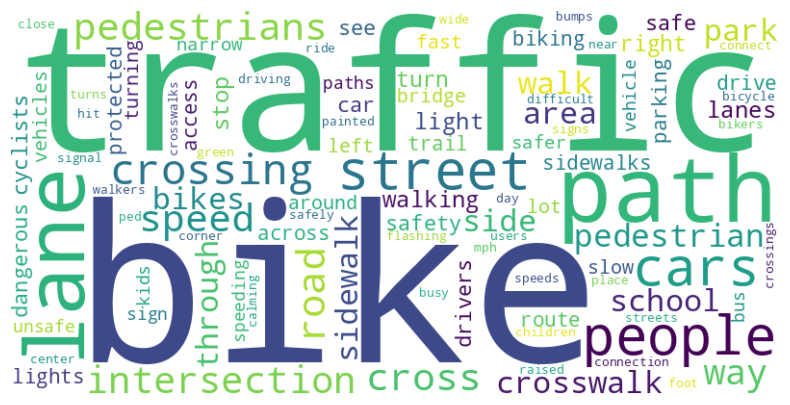

In [19]:
cloud = WordCloud(width=800, height=400, background_color="white")

wc = cloud.generate_from_frequencies(
    pd.Series(freq["Frequency"].values, index=freq["Word"]).to_dict()
)

plt.figure(figsize=(10, 5))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()